# Rhodococcus Data with Shapley


### Set up imports

In [1]:
# !pip install shap
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rhodo_df = pd.read_csv('data/rhodo_data.csv')
rhodo_df.head(2)

,sample,2-aminoadipic acid,2'-Deoxycytidine 5'-monophosphoric acid,3-phosphoglycerate,4-aminobutyric acid (GABA),Adenine,Arachidic acid,Beta-alanine,Carbonate ion,Citric acid,...,Maltotriose,Melibiose,O-phospho-L-serine,PhlorobenzoPHEnone,Phytanic acid,Porphine,Shikimate-3-phosphate,Turanose,Unknown - Carbohydrate 001,Unknown - Carbohydrate 002
0,SG_1,361520.3973,158448.3434,322605.0733,677195.0481,710902.5555,21587.08363,1742924.769,2187317.706,73643.82800,...,197109.0981,154515.4823,912327.9657,54886.78433,53255.60385,1.567848e+06,79592.7445,41592.87779,106902.77270,178790.73570
1,SG_2,227309.5576,213583.3661,312837.4294,575822.1064,510742.4749,30589.63167,1362157.065,2078919.836,85094.11759,...,132211.9452,178537.3888,546466.6858,13966.87377,54527.47672,9.428716e+05,101591.3118,125701.00550,92505.27963,61108.72574


In [3]:
sample_values = rhodo_df['sample']

new_sample_names = []

for sample in sample_values:
    new_sample_name = sample.split('_')[0]
    
    new_sample_names.append(new_sample_name)

rhodo_df['sample'] = new_sample_names
rhodo_df.head(2)


,sample,2-aminoadipic acid,2'-Deoxycytidine 5'-monophosphoric acid,3-phosphoglycerate,4-aminobutyric acid (GABA),Adenine,Arachidic acid,Beta-alanine,Carbonate ion,Citric acid,...,Maltotriose,Melibiose,O-phospho-L-serine,PhlorobenzoPHEnone,Phytanic acid,Porphine,Shikimate-3-phosphate,Turanose,Unknown - Carbohydrate 001,Unknown - Carbohydrate 002
0,SG,361520.3973,158448.3434,322605.0733,677195.0481,710902.5555,21587.08363,1742924.769,2187317.706,73643.82800,...,197109.0981,154515.4823,912327.9657,54886.78433,53255.60385,1.567848e+06,79592.7445,41592.87779,106902.77270,178790.73570
1,SG,227309.5576,213583.3661,312837.4294,575822.1064,510742.4749,30589.63167,1362157.065,2078919.836,85094.11759,...,132211.9452,178537.3888,546466.6858,13966.87377,54527.47672,9.428716e+05,101591.3118,125701.00550,92505.27963,61108.72574


In [4]:
y = rhodo_df['sample']
X = rhodo_df.drop('sample', axis=1)


X.head(2)

,2-aminoadipic acid,2'-Deoxycytidine 5'-monophosphoric acid,3-phosphoglycerate,4-aminobutyric acid (GABA),Adenine,Arachidic acid,Beta-alanine,Carbonate ion,Citric acid,Dehydroalanine,...,Maltotriose,Melibiose,O-phospho-L-serine,PhlorobenzoPHEnone,Phytanic acid,Porphine,Shikimate-3-phosphate,Turanose,Unknown - Carbohydrate 001,Unknown - Carbohydrate 002
0,361520.3973,158448.3434,322605.0733,677195.0481,710902.5555,21587.08363,1742924.769,2187317.706,73643.82800,317216.4194,...,197109.0981,154515.4823,912327.9657,54886.78433,53255.60385,1.567848e+06,79592.7445,41592.87779,106902.77270,178790.73570
1,227309.5576,213583.3661,312837.4294,575822.1064,510742.4749,30589.63167,1362157.065,2078919.836,85094.11759,336929.7630,...,132211.9452,178537.3888,546466.6858,13966.87377,54527.47672,9.428716e+05,101591.3118,125701.00550,92505.27963,61108.72574


In [5]:
model = RandomForestClassifier(random_state = 42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [6]:
# Create Shap explainer
explainer = shap.Explainer(model, X)
# Get Shapley values
shap_values = explainer(X)
# Dimensions of shap values
shap_values.shape

# type(shap_values)

(18, 86, 5)

SG


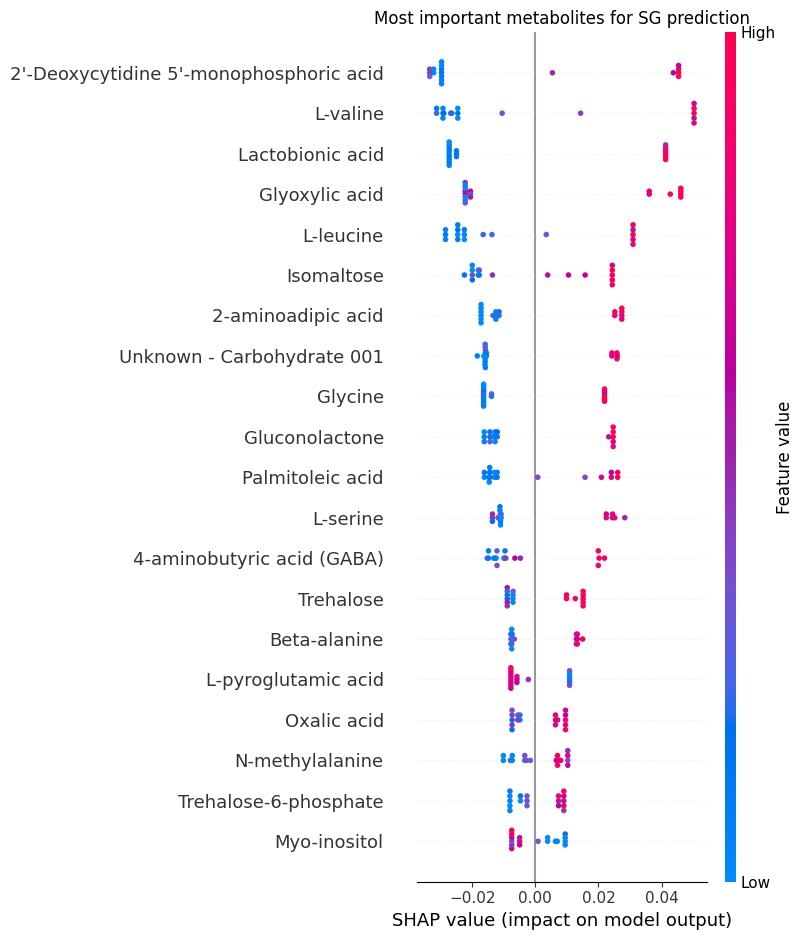

GLC


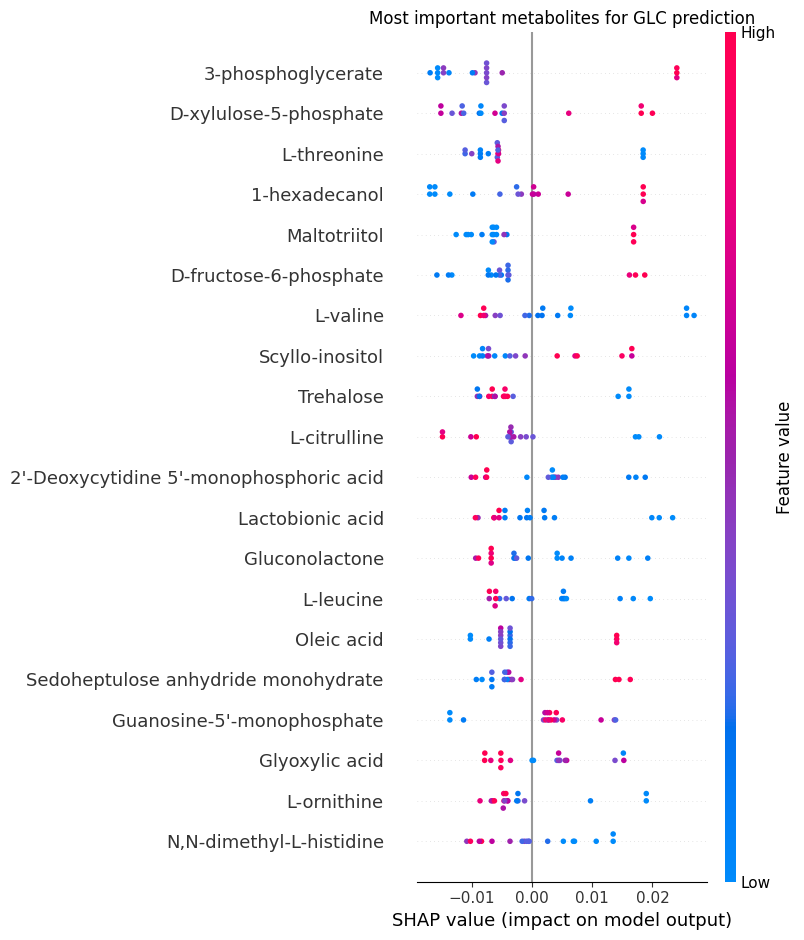

PHE


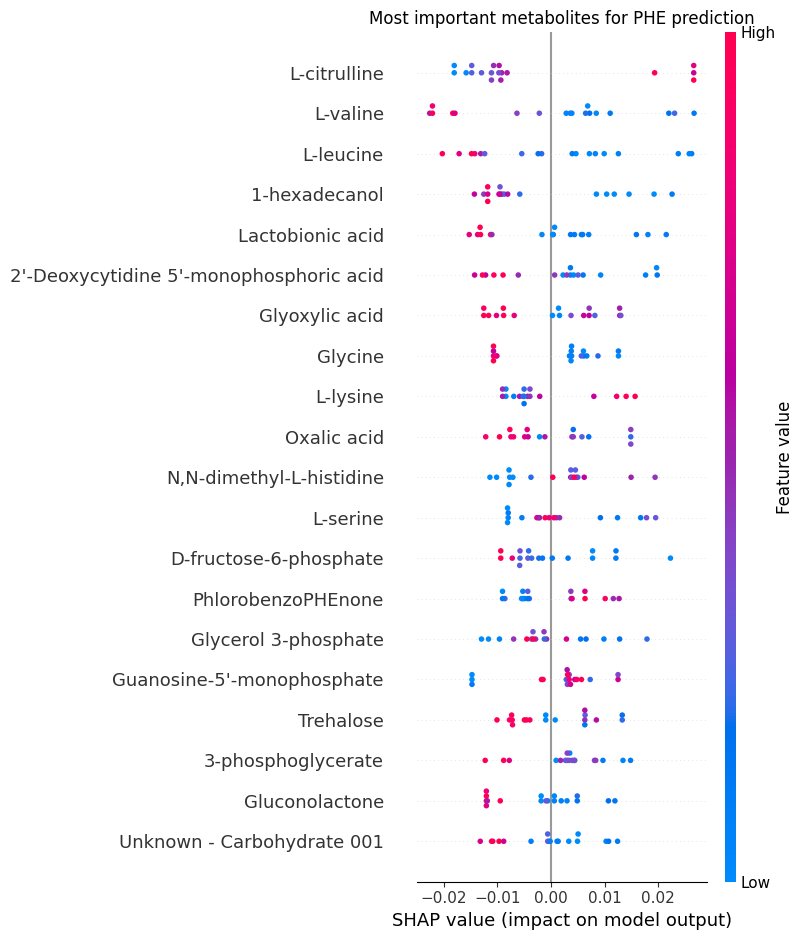

GLC/PHE


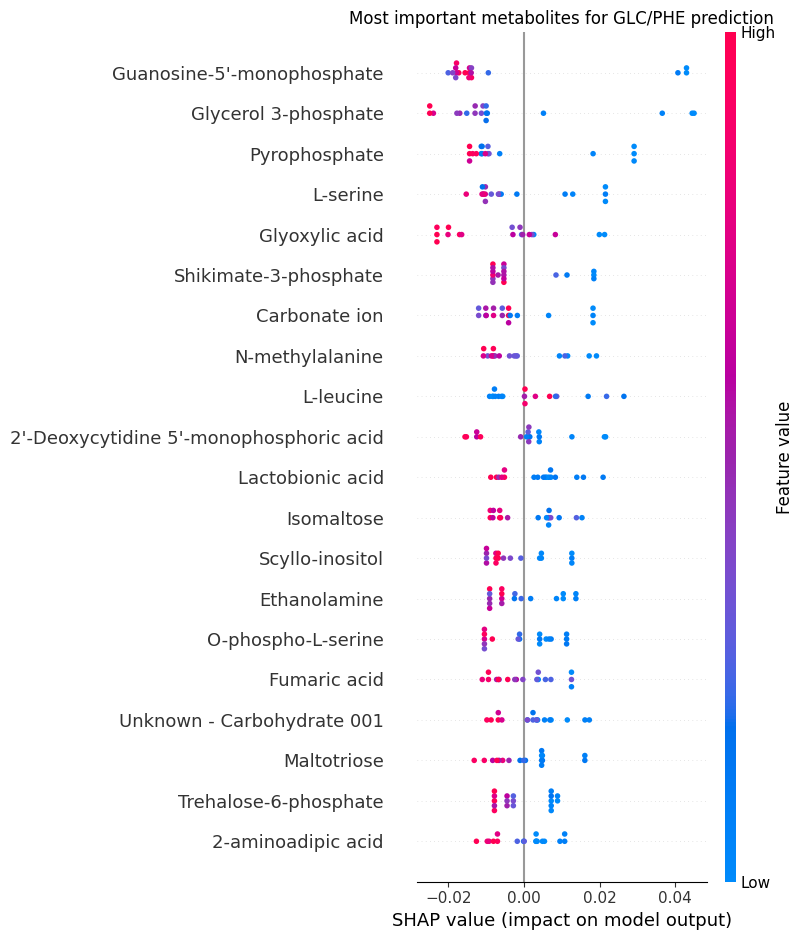

AMIX


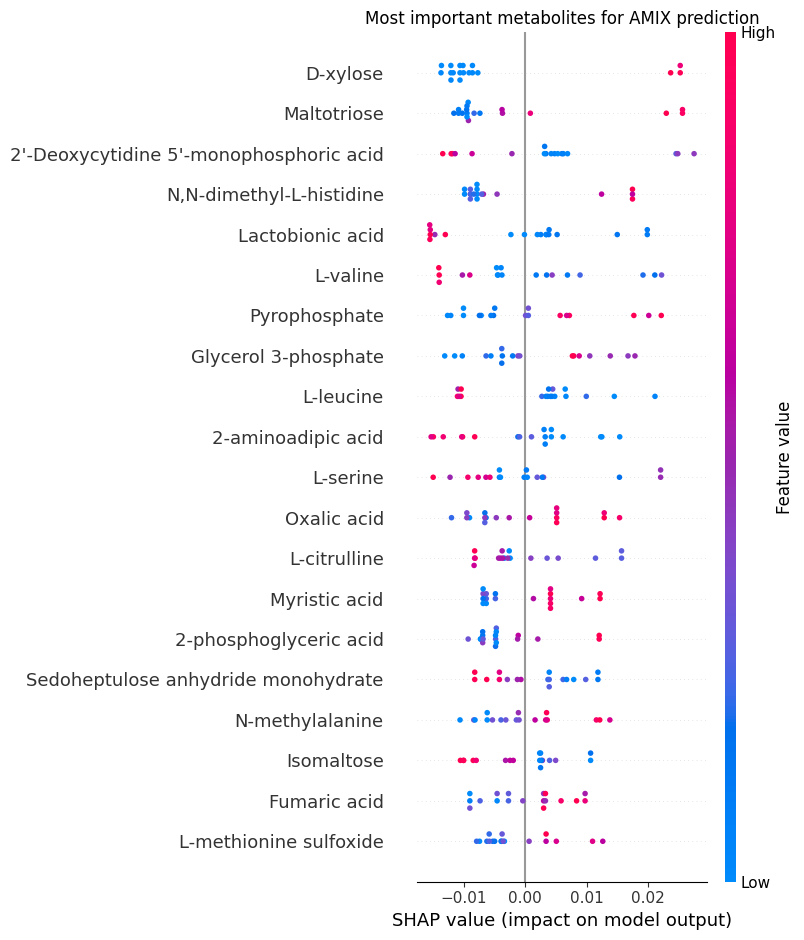

In [7]:
explainer2 = shap.TreeExplainer(model)
shap_values2 = explainer2(X)
Sample_names = ['SG', 'GLC', 'PHE', 'GLC/PHE', 'AMIX']


for index,sample in enumerate(Sample_names):
    print(sample)
    plt.title(f"Most important metabolites for {sample} prediction")
    shap.summary_plot(shap_values2[:,:,index])


In [8]:
shap_values_numbers = shap_values2.values

# for index,sample in enumerate(Sample_names):
#     print(sample)
#     shap_df = pd.DataFrame(shap_values_numbers[:, :, index], columns = X.columns, index = y)
    
#     display(shap_df)

## Reordered Tables

In [9]:
for index, sample in enumerate(Sample_names):
    print(sample)
    shap_df = pd.DataFrame(shap_values_numbers[:, :, index], columns=X.columns, index=y)
    
    # Sort columns by absolute mean Shapley value for each class
    shap_df2 = shap_df.reindex(shap_df.abs().mean().sort_values(ascending=False).index, axis=1)
    
    display(shap_df2)

SG


,2'-Deoxycytidine 5'-monophosphoric acid,L-valine,Lactobionic acid,Glyoxylic acid,L-leucine,Isomaltose,2-aminoadipic acid,Unknown - Carbohydrate 001,Glycine,Gluconolactone,...,Methyl phosphate,L-malic acid,D-xylulose-5-phosphate,L-isoleucine,L-homoserine,L-glutamic acid,Adenosine-5-monophosphate,L-cysteine,Lauric acid,Unknown - Carbohydrate 002
sample,,,,,,,,,,,,,,,,,,,,,
SG,-0.033472,-0.010517,-0.025000,0.046111,-0.016528,-0.013590,-0.017201,-0.015892,-0.013889,-0.014390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SG,-0.033472,-0.028993,-0.025000,-0.022222,-0.024583,-0.019979,-0.017201,-0.015892,-0.016389,-0.014390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SG,-0.033472,-0.026813,-0.025000,-0.022222,-0.028472,-0.019979,-0.017201,-0.015809,-0.013889,-0.014390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLC,-0.029722,-0.029284,-0.027308,-0.022222,-0.022500,-0.018056,-0.017201,-0.015833,-0.016389,-0.016201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLC,-0.029722,-0.029284,-0.027308,-0.022222,-0.022500,-0.018056,-0.017201,-0.015916,-0.016389,-0.016201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLC,-0.029722,-0.029284,-0.027308,-0.022222,-0.022500,-0.019979,-0.017201,-0.015916,-0.016389,-0.016201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PHE,-0.029722,-0.024580,-0.027308,-0.022222,-0.013750,-0.022479,-0.012500,-0.018403,-0.016389,-0.012778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PHE,-0.032222,-0.024580,-0.027308,-0.022222,-0.024583,-0.017756,-0.012500,-0.015945,-0.016389,-0.012778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PHE,-0.032222,-0.024580,-0.027308,-0.022222,-0.024583,-0.017756,-0.012500,-0.015945,-0.016389,-0.012778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


GLC


,3-phosphoglycerate,D-xylulose-5-phosphate,L-threonine,1-hexadecanol,Maltotriitol,D-fructose-6-phosphate,L-valine,Scyllo-inositol,Trehalose,L-citrulline,...,Dehydroalanine,Phosphate Ion,Phytanic acid,Trehalose-6-phosphate,"1,4-butanediol",L-tyrosine,Methyl phosphate,Stearic acid,Adenosine-5-monophosphate,Unknown - Carbohydrate 002
sample,,,,,,,,,,,,,,,,,,,,,
SG,-0.009421,-0.011548,-0.005724,-0.005291,-0.010036,-0.003811,-0.005256,0.004203,-0.006567,-0.003955,...,-0.000625,-0.000556,0.000243,-0.000364,0.000549,0.000352,0.0,0.0,0.0,0.0
SG,-0.014644,-0.008442,-0.007217,-0.001738,-0.010557,-0.005353,0.001006,0.007165,-0.003106,-0.003427,...,-0.000625,-0.004726,0.000459,0.000956,-0.000741,0.000352,0.0,0.0,0.0,0.0
SG,-0.014644,-0.008442,-0.005724,-0.002524,-0.008265,-0.005353,-0.000432,0.007519,-0.006567,-0.003427,...,-0.000625,-0.001450,0.000243,0.000956,-0.000741,0.000352,0.0,0.0,0.0,0.0
GLC,0.024043,0.018144,0.018458,0.018473,0.016881,0.017187,0.025659,0.014949,0.016098,0.021160,...,0.002484,0.001182,0.001954,0.003641,0.001725,0.000352,0.0,0.0,0.0,0.0
GLC,0.024043,0.019995,0.018458,0.018473,0.016881,0.018727,0.026905,0.016583,0.016098,0.017737,...,0.002484,0.000362,0.001954,0.001071,0.001725,0.000352,0.0,0.0,0.0,0.0
GLC,0.024043,0.018144,0.018458,0.018473,0.016881,0.016187,0.025659,0.016583,0.014316,0.017185,...,0.002484,0.001182,-0.000765,-0.002212,0.001725,0.002481,0.0,0.0,0.0,0.0
PHE,-0.015617,-0.011683,-0.009958,-0.016928,-0.006564,-0.007222,0.004293,-0.008170,-0.008651,-0.002993,...,0.000880,0.000203,0.000624,-0.000347,0.000549,0.000352,0.0,0.0,0.0,0.0
PHE,-0.015617,-0.011294,-0.011063,-0.016928,-0.006564,-0.006726,0.006393,-0.008170,-0.009034,-0.001852,...,0.000880,0.000203,0.000258,-0.000046,0.000549,0.000352,0.0,0.0,0.0,0.0
PHE,-0.015617,-0.008702,-0.011063,-0.013595,-0.006564,-0.007202,0.006479,-0.009652,-0.009034,0.000185,...,0.000880,0.000362,0.000258,-0.000522,0.000285,0.000352,0.0,0.0,0.0,0.0


PHE


,L-citrulline,L-valine,L-leucine,1-hexadecanol,Lactobionic acid,2'-Deoxycytidine 5'-monophosphoric acid,Glyoxylic acid,Glycine,L-lysine,Oxalic acid,...,Arachidic acid,L-methionine sulfoxide,"1,4-butanediol",Turanose,L-malic acid,Stearic acid,Uracil,Adenosine-5-monophosphate,Lauric acid,Unknown - Carbohydrate 002
sample,,,,,,,,,,,,,,,,,,,,,
SG,-0.012973,-0.002190,-0.001758,-0.008731,0.005897,0.005045,-0.008842,0.005646,-0.005868,-0.007482,...,0.000305,-0.000261,0.001177,-0.000616,0.000293,0.0,0.0,0.0,0.0,0.0
SG,-0.014798,0.007193,0.009917,-0.012540,0.003648,0.000674,0.008176,0.008753,-0.009042,-0.012187,...,0.000305,0.000479,-0.000710,0.000148,0.000293,0.0,0.0,0.0,0.0,0.0
SG,-0.014798,0.006451,0.008261,-0.005831,0.004369,0.002942,0.007111,0.006670,-0.009042,-0.009612,...,0.000305,-0.000063,-0.000710,0.000308,0.000293,0.0,0.0,0.0,0.0,0.0
GLC,-0.018056,0.003885,0.007149,-0.011815,0.000663,0.003621,0.007090,0.003826,-0.005028,0.005761,...,-0.002616,-0.000121,0.000239,0.000308,0.000479,0.0,0.0,0.0,0.0,0.0
GLC,-0.015834,0.002834,0.012559,-0.011815,-0.001696,0.005982,0.001581,0.006049,-0.005028,0.003894,...,-0.002616,0.000537,0.000239,0.000148,0.000479,0.0,0.0,0.0,0.0,0.0
GLC,-0.018056,0.003588,0.004649,-0.011815,0.000295,0.003621,0.003731,0.003826,-0.005028,0.007032,...,-0.002616,0.000537,0.000086,0.000148,0.000479,0.0,0.0,0.0,0.0,0.0
PHE,-0.008201,0.011029,-0.005458,0.008461,0.005657,0.009253,0.006096,0.003769,-0.006950,-0.002139,...,0.000156,-0.000299,0.001177,-0.000616,-0.000411,0.0,0.0,0.0,0.0,0.0
PHE,-0.011113,0.008437,-0.002403,0.011794,0.000422,0.004205,0.000266,0.003439,-0.008421,0.004142,...,0.000156,-0.000021,0.000205,-0.000296,-0.000411,0.0,0.0,0.0,0.0,0.0
PHE,-0.011113,0.006834,0.003945,0.010370,0.007031,0.002242,0.001398,0.003728,-0.008421,0.004142,...,-0.000208,-0.000021,0.000273,-0.000296,-0.000208,0.0,0.0,0.0,0.0,0.0


GLC/PHE


,Guanosine-5'-monophosphate,Glycerol 3-phosphate,Pyrophosphate,L-serine,Glyoxylic acid,Shikimate-3-phosphate,Carbonate ion,N-methylalanine,L-leucine,2'-Deoxycytidine 5'-monophosphoric acid,...,Palmitic acid,Uracil,Stearic acid,L-proline,Adenosine-5-monophosphate,"Benzene-1,2,4-triol",Lactic acid,L-cysteine,Lauric acid,Unknown - Carbohydrate 002
sample,,,,,,,,,,,,,,,,,,,,,
SG,-0.015522,-0.012866,-0.014343,-0.010166,-0.019907,-0.005278,-0.008014,-0.008203,0.008361,0.001116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SG,-0.017792,-0.017686,-0.014343,-0.010942,-0.000599,-0.008180,-0.009946,-0.010610,-0.005586,0.001322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SG,-0.017189,-0.016922,-0.014343,-0.010166,-0.001016,-0.006816,-0.008014,-0.008588,-0.005903,0.001283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLC,-0.019991,-0.024865,-0.006381,0.010881,-0.002891,-0.008180,-0.001724,-0.002555,-0.008109,0.004063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLC,-0.018001,-0.024865,-0.011255,-0.005997,0.002618,-0.008180,-0.010057,0.009389,-0.009053,0.001563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLC,-0.018811,-0.023895,-0.011255,0.012915,0.002132,-0.008180,-0.010057,0.011562,-0.008303,0.004063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PHE,0.040687,0.036556,0.029115,0.021543,0.008313,0.018487,0.018266,0.017247,0.021839,0.012688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PHE,0.042955,0.044450,0.029115,0.021543,0.021322,0.018487,0.018266,0.019173,0.026427,0.021592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PHE,0.042955,0.044958,0.029115,0.021543,0.019933,0.018487,0.018266,0.010840,0.016969,0.021275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AMIX


,D-xylose,Maltotriose,2'-Deoxycytidine 5'-monophosphoric acid,"N,N-dimethyl-L-histidine",Lactobionic acid,L-valine,Pyrophosphate,Glycerol 3-phosphate,L-leucine,2-aminoadipic acid,...,Uracil,L-PHEnylalanine,Palmitic acid,Maleamic acid,Thymine,Adenine,Methyl phosphate,Stearic acid,Adenosine-5-monophosphate,Unknown - Carbohydrate 002
sample,,,,,,,,,,,,,,,,,,,,,
SG,0.025259,0.022991,0.024577,0.017478,0.019893,0.022223,0.020132,0.013856,0.009948,0.012489,...,-0.000406,0.001435,0.002400,-0.000208,0.001897,0.0,0.0,0.0,0.0,0.0
SG,0.025259,0.025630,0.027518,0.017478,0.014997,0.021117,0.017703,0.016751,0.014515,0.012302,...,0.003389,0.001435,0.002400,0.002910,0.000479,0.0,0.0,0.0,0.0,0.0
SG,0.023699,0.025630,0.024860,0.017478,0.019893,0.019193,0.022170,0.017885,0.021148,0.015399,...,0.000813,-0.002870,0.002400,-0.000486,0.000479,0.0,0.0,0.0,0.0,0.0
GLC,-0.007728,-0.003780,0.004782,-0.007866,-0.000127,-0.003797,-0.007180,0.007904,0.006636,0.004255,...,-0.001694,-0.000509,-0.000725,-0.000486,0.000479,0.0,0.0,0.0,0.0,0.0
GLC,-0.010067,-0.003711,0.003374,-0.009888,0.001975,-0.004429,-0.007467,0.007684,0.004354,0.006176,...,-0.001694,-0.000509,-0.000725,-0.000486,0.000479,0.0,0.0,0.0,0.0,0.0
GLC,-0.010146,-0.011632,0.005963,-0.009888,-0.002337,-0.003937,-0.005165,0.008794,0.006511,0.004255,...,-0.001694,0.000255,0.000325,-0.000486,0.000479,0.0,0.0,0.0,0.0,0.0
PHE,-0.008604,-0.009549,0.004225,-0.007858,0.003886,0.006883,-0.010064,-0.010256,0.002710,0.003253,...,-0.000215,0.000255,0.000325,-0.000208,0.000293,0.0,0.0,0.0,0.0,0.0
PHE,-0.008604,-0.010868,0.003123,-0.007858,0.003834,-0.004517,-0.010064,-0.013124,0.003815,0.003253,...,-0.000215,0.000116,0.000325,-0.000208,0.000293,0.0,0.0,0.0,0.0,0.0
PHE,-0.009160,-0.010868,0.005301,-0.007858,0.002538,-0.004667,-0.012662,-0.011498,0.004109,0.003068,...,-0.000215,0.000116,0.000325,0.000729,-0.000208,0.0,0.0,0.0,0.0,0.0
